#### **PyTorch**

In [1]:
import torch
import torch.nn.functional as F
print(f"PyTorch Version: {torch.__version__}")

import torch
print(f"Cude is available: {torch.cuda.is_available()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.3.0+cu121
Cude is available: True
Device name: NVIDIA H100 PCIe


#### **Import Other Libraries**

In [2]:
# Standard library imports
import os

# Deep learning libraries
import torch
from torch.utils.data import DataLoader
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, DataCollatorWithPadding

# Text processing libraries
import tiktoken
import csv
import pandas as pd

# Utility libraries
import numpy as np
import random
import math
from tqdm import tqdm
from itertools import chain
from IPython.display import display, Markdown
import textwrap

# Custom libraries  
from llmft.train import DecoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict

# Visualization libraries
import seaborn as sns  # Assuming seaborn is installed

# NLP utility (assuming trics is a library/module)
from trics.nlp.utils import to_markdown

# Configure GPU usage and tokenizer parallelism
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Dataset libraries (can be grouped together)
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

#### **Parameters**

In [3]:
seed = 0
noise = False 
version = 1 
lr = 1e-4 
sample_size = 200
warmup_ratio = 0.25
batch_size = 8
epochs = 30
patience = 10
gamma = 0.0
prompt = True 
test_size = 0.25
gradient_accumulation = 8

#### **Seed**

In [4]:
np.random.seed(seed)

#### **Set Up Paths**

In [5]:
data_csv = f'./../../../toy-data/exp2/data_{version}.csv'

#### **Set Up Plotting**

In [6]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../../styles/Newsreader
/home/ubuntu/llmft/styles/Newsreader/static/Newsreader_36pt/Newsreader_36pt-BoldItalic.ttf


#### **First Stage Function**

In [7]:
conditions_not_covered = [
    "Short-term illnesses",
    "Temporary exhaustion",
    "Behavioral Traits and Conditions",
    "Having a quick temper without any underlying medical condition",
    "Certain Addictions",
    "Substance abuse disorders",
    "good health"
]

conditions_covered = [
    "Mobility impairments",
    "Visual impairments",
    "Hearing impairments",
    "Chronic illnesses",
    "Respiratory disorders",
    "Cardiovascular conditions",
    "Intellectual disabilities",
    "Learning disabilities",
    "Autism spectrum disorders",
    "Psychiatric disorders",
    "Traumatic brain injuries",
    "Alzheimer's disease and other dementias"
]

disabilities = conditions_covered + conditions_not_covered

# Create a list of (0,1)s
severity_indicator = [1 if disability in conditions_covered else 0 for disability in disabilities]

def fstage(var1, var2, var3, var4, var5, var6, var7, var8, var9):
    return 1*var9 #0.02 + 0.35*severity_indicator[var5] + 0.35*var9

#### **Read in Data**

In [8]:
import re 

def remove_newlines(text):
    return re.sub(r'\n+', '', text)

string_b = 'Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.\n\n Description:'
string1 = "\n\n Note: The tenant has access to a free lawyer."
string0 = "\n\n Note: The tenant does not have access to a free lawyer."
if prompt:
    string1 += " Access to a lawyer does not mean the tenant will be represented in court by a lawyer." \
        " If the tenant is given access to a lawyer, they must apply for representation." \
        " Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications." \
        " Providers can differ over what they consider to be a dissability."\
        " If a tenant's application is selected, they must follow-up with the provider to arange for legal representation." \
        " Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation."

# Read in Data Set
df = pd.read_csv(data_csv)
df['Description'] = df['Description'].apply(lambda x: remove_newlines(x))


# Subsample Observations
indices = np.random.choice(df.index, size=sample_size, replace=False)
df = df.loc[indices].reset_index(drop=True)

# Apply First Stage Function
df['FStage_Value'] = df.apply(lambda row: fstage(
                                                 row['Var1'], 
                                                 row['Var2'], 
                                                 row['Var3'], 
                                                 row['Var4'], 
                                                 row['Var5'],
                                                 row['Var6'],
                                                 row['Var7'],
                                                 row['Var8'],
                                                 row['Var9']), axis=1)

# If Noise: Shuffle the first stage values
if noise: 
    df['FStage_Value'] = df['FStage_Value'].sample(frac=1).reset_index(drop=True)

# Sample Instrumental Values  
df['Instrument'] = np.random.binomial(n=1, p=0.5, size=sample_size)

# Text + Instrument
df['FullDescription'] = np.where(df['Instrument'] == 1,
                             string_b + df['Description'] + string1,
                             string_b + df['Description'] + string0)

# Text + Instrument == 1
df['Treated_FullDescription'] = df.apply(lambda row: string_b + row['Description'].replace("\n", "") + string1, axis=1)

# Text + Instrument == 0
df['Control_FullDescription'] = df.apply(lambda row: string_b + row['Description'].replace("\n", "") + string0, axis=1)

# Sample Treatment Values
df['Treatment'] = np.random.binomial(n=1, p= df['FStage_Value'] * df['Instrument'], size=sample_size)

# Sample Outcome Values
df['Outcome'] =  (1. +  2.*(df['FStage_Value'] > 0.))*df['Treatment'] + 0.1*np.random.normal(size=sample_size)

#### **Plot**

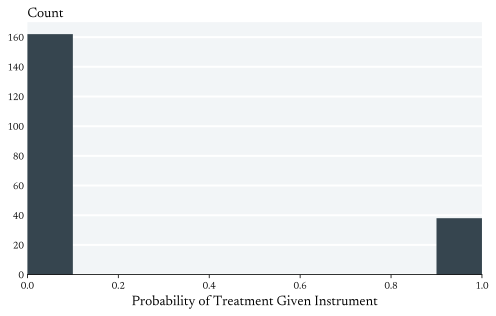

In [9]:
fig = plt.figure(dpi=300, tight_layout=True, figsize=(7, 4.5))
ax = plt.axes(facecolor=(.95, .96, .97))

# Plot customizations
for key in 'left', 'right', 'top':
    ax.spines[key].set_visible(False)
ax.text(0., 1.02, s='Count', transform=ax.transAxes, size=14)
ax.yaxis.set_tick_params(length=0)
ax.yaxis.grid(True, color='white', linewidth=2)
ax.set_axisbelow(True)
plt.hist(df['FStage_Value'], color='#36454F')
plt.xlim(0, 1)
plt.xlabel('Probability of Treatment Given Instrument', size=14)
plt.show()

##### **Set Up Device**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


#### **Qlora**

In [11]:
from peft import LoraConfig, get_peft_model 
from transformers import BitsAndBytesConfig

# ----- QUANTIZATION -------# 
# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = True

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = True

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# ----- LORA -------# 

# lora_config = LoraConfig(
#     r=8,
#     target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
#     task_type="CAUSAL_LM",
# )
additional_modules = ["attn_proj", "ff_proj"]
target_modules = ["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"] + additional_modules

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05, 
    target_modules='all-linear',
    bias="none",
    task_type="CAUSAL_LM",
)

Your GPU supports bfloat16: accelerate training with bf16=True


#### **Instantiate Model**

In [12]:
model_name = 'meta-llama/Meta-Llama-3-8B-Instruct' #"microsoft/Phi-3-mini-4k-instruct"#'meta-llama/Meta-Llama-3-8B-Instruct' #"microsoft/Phi-3-mini-4k-instruct"# #"microsoft/Phi-3-mini-4k-instruct" #meta-llama/Meta-Llama-3-8B-Instruct" 

from transformers.utils import is_flash_attn_2_available
print(is_flash_attn_2_available())
model = AutoModelForCausalLM.from_pretrained(model_name, 
                                            device_map="auto", 
                                            torch_dtype=torch.bfloat16,
                                            trust_remote_code=True,
                                            attn_implementation="flash_attention_2")# So we can do gradient checkpointing

# Enable gradient checkpointing
model.gradient_checkpointing_enable()

model.config.use_cache = False # Conflixt with gradient checkpointing
model.config.pretraining_tp = 1
model.generation_config.temperature = 0.001
model.enable_input_require_grads()
print(model.generation_config)

# model = get_peft_model(model, lora_config)
# print(model.print_trainable_parameters())
#quantization_config=bnb_config, 

True


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

GenerationConfig {
  "bos_token_id": 128000,
  "do_sample": true,
  "eos_token_id": [
    128001,
    128009
  ],
  "max_length": 4096,
  "temperature": 0.001,
  "top_p": 0.9
}



#### **Tokenizer**

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
# Set the padding side to left
tokenizer.padding_side = 'left'

def tokenizer_function(example):
  return tokenizer.apply_chat_template(example["messages"], 
                                                          tokenize=True, 
                                                          add_generation_prompt=False, 
                                                          return_dict=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### **Create Dataset**

In [14]:
if model_name == 'microsoft/Phi-3-mini-4k-instruct':
    # Initialize the dataset list
    dataset = []
    treated_dataset = []
    control_dataset = []

    for index, row in df.iterrows():
        entry = [
            {'content': f"Task: {row['FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]

        treated_entry = [
            {'content': f"Task: {row['Treated_FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]
        
        control_entry = [
            {'content': f"Task: {row['Control_FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]

        dataset.append(entry)
        treated_dataset.append(treated_entry)
        control_dataset.append(control_entry)

    dataset = Dataset.from_dict({'messages': dataset})
    treated_dataset = Dataset.from_dict({'messages': treated_dataset})
    control_dataset = Dataset.from_dict({'messages': control_dataset})

else:
    # Initialize the dataset list
    dataset = []
    treated_dataset = []
    control_dataset = []

    for index, row in df.iterrows():
        entry = [
            {'content': 'You are a housing court clerk', 'role': 'system'},
            {'content': f"Task: {row['FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]
        dataset.append(entry)


        treated_entry = [
            {'content': 'You are a housing court clerk', 'role': 'system'},
            {'content': f"Task: {row['Treated_FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]
        treated_dataset.append(treated_entry)

        control_entry = [
            {'content': 'You are a housing court clerk', 'role': 'system'},
            {'content': f"Task: {row['Treated_FullDescription']}", 'role': 'user'},
            {'content': 'No' if row['Treatment'] == 0 else 'Yes', 'role': 'assistant'}
        ]
        control_dataset.append(control_entry)

    dataset = Dataset.from_dict({'messages': dataset})
    treated_dataset = Dataset.from_dict({'messages': treated_dataset})
    control_dataset = Dataset.from_dict({'messages': control_dataset})

#### **Token Length**

(array([ 8., 44., 46., 13.,  1.,  2., 17., 39., 20., 10.]),
 array([132., 153., 174., 195., 216., 237., 258., 279., 300., 321., 342.]),
 <BarContainer object of 10 artists>)

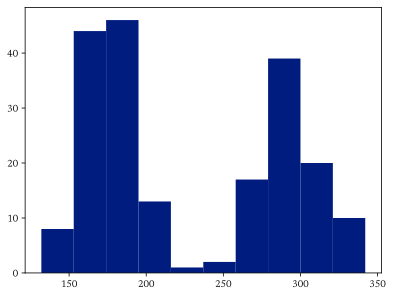

In [15]:
batched_tokens = tokenizer.apply_chat_template(dataset['messages'], tokenize=True, batched=True)
plt.hist(list(map(len, batched_tokens)))

#### **Input Type**

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

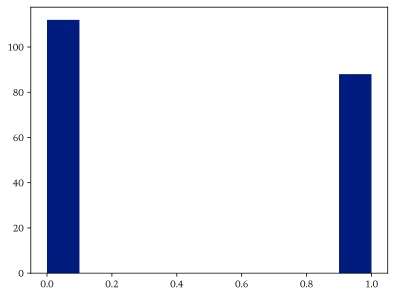

In [16]:
if model_name == 'microsoft/Phi-3-mini-4k-instruct':
    def get_input_id(example):
        example['type_indicator'] = 1 if 'The tenant has access to a free lawyer' in example['messages'][0]['content'] else 0 
        return example
else:
    def get_input_id(example):
        example['type_indicator'] = 1 if 'The tenant has access to a free lawyer' in example['messages'][1]['content'] else 0 
        return example

dataset = dataset.map(get_input_id, batched=False)
treated_dataset = treated_dataset.map(get_input_id, batched=False)
control_dataset = control_dataset.map(get_input_id, batched=False)
plt.hist(dataset['type_indicator'])
plt.show()

In [17]:
tokens = tokenizer.apply_chat_template(dataset['messages'][0], tokenizer=False)
tokenizer.decode(tokens[-1])

'<|eot_id|>'

#### **Output Type**

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

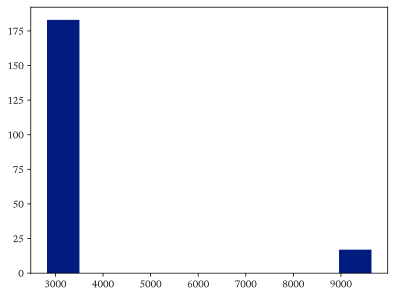

In [18]:
if model_name == 'microsoft/Phi-3-mini-4k-instruct':
    def get_output_id(example):
        string = example['messages'][1]['content']
        example['target_token'] = tokenizer.encode(string, add_special_tokens=False)[0] 
        return example

else:
    def get_output_id(example):
        string = example['messages'][2]['content']
        example['target_token'] = tokenizer.encode(string, add_special_tokens=False)[0] 
        return example

def get_ys_id(example):
    example['yes_token'] = tokenizer.encode('Yes', add_special_tokens=False)[0] 
    return example


dataset = dataset.map(get_output_id, batched=False)
dataset = dataset.map(get_ys_id, batched=False)
dataset = dataset.add_column("fstage", df['FStage_Value'].values.tolist())
dataset = dataset.add_column("outcome", df['Outcome'].values.tolist())

treated_dataset = treated_dataset.map(get_output_id, batched=False)
treated_dataset = treated_dataset.map(get_ys_id, batched=False)
treated_dataset = treated_dataset.add_column("fstage", df['FStage_Value'].values.tolist())
treated_dataset = treated_dataset.add_column("outcome", df['Outcome'].values.tolist())

control_dataset = control_dataset.map(get_output_id, batched=False)
control_dataset = control_dataset.map(get_ys_id, batched=False)
control_dataset = control_dataset.add_column("fstage", df['FStage_Value'].values.tolist())
control_dataset = control_dataset.add_column("outcome", df['Outcome'].values.tolist())

plt.hist(dataset['target_token'])
plt.show()

#### **Data Loaders**

In [19]:
tokenized_dataset = dataset.map(tokenizer_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['messages'])
tokenized_dataset_split = tokenized_dataset.train_test_split(test_size=test_size, seed=42)
   
tokenized_treated_dataset = treated_dataset.map(tokenizer_function, batched=True)
tokenized_treated_dataset = tokenized_treated_dataset.remove_columns(['messages'])
 

tokenized_control_dataset = control_dataset.map(tokenizer_function, batched=True)
tokenized_control_dataset = tokenized_control_dataset.remove_columns(['messages'])
 

all_loader = DataLoader(tokenized_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
treated_loader = DataLoader(tokenized_treated_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)
control_loader = DataLoader(tokenized_control_dataset, batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=False)

train_loader = DataLoader(tokenized_dataset_split['train'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
test_loader = DataLoader(tokenized_dataset_split['test'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

#### **Optimizer**

In [20]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler =transformers.optimization.get_cosine_schedule_with_warmup(optimizer,num_warmup_steps= len(train_loader)*2, num_training_steps = len(train_loader)*epochs, num_cycles= 1) #int(warmup_ratio*len(train_loader)*epochs)

#### **Class Weights**

In [21]:
class_weights = torch.tensor([1., 1.], device=device) #torch.tensor([1-n_positive/n_samples, n_positive/n_samples], device=device)
# criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='output', reduction='none')
# criterion = torch.nn.CrossEntropyLoss(reduction='mean') 

# # Assume 'class_counts' is a list containing the number of samples for each class
# n_samples = len(dataset['train']); print(f"Number of Observations: {n_samples}")
# n_positive = sum(dataset['train']['type_indicator']); print(f"Number of Positive Outcomes: {n_positive}")
# class_weights = torch.tensor([1., 1.], device=device) 
# frac_positive = (n_positive/n_samples)
# class_weights = torch.tensor([1/ (1-frac_positive), 1 / frac_positive], device=device)
# class_weights = class_weights/sum(class_weights)
criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='input')
print(criterion.gamma)
print(f"Class Weights: {class_weights}")

0.0
Class Weights: tensor([1., 1.], device='cuda:0')


#### **Trainer**

In [22]:
yuri = DecoderTrainer(model,
                    tokenizer,
                    optimizer, 
                    scheduler,
                    criterion, 
                    device, 
                    verbose=False, 
                    threshold=2,
                    gradient_accumulation=2)

print(yuri.verbose)
early_stopping = EarlyStopping(patience)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


False


#### **Training**

In [23]:
evaluation_losses = [yuri.evaluate(test_loader)[1]]
training_losses = [yuri.evaluate(train_loader)[1]]
lr_history = []
#recall_history = [yuri.compute_recall(test_loader)]
pbar =  tqdm(range(epochs), desc=f'Epoch: 0, Train Loss: {training_losses[0]:.3f}, Val Loss: {evaluation_losses[0]:.3f}')  #,  rYes: {recall_history[0][1]:.3f}')

for epoch in pbar:
    train_loss = yuri.train(train_loader)
    training_losses.append(train_loss[1])
    val_loss = yuri.evaluate(test_loader)
    evaluation_losses.append(val_loss[1])
    lr_history.append(get_lr(optimizer))

    #recall = yuri.compute_recall(test_loader)
    #recall_history.append(recall)

    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {train_loss[1]:.4f}, Val Loss: {val_loss[1]:.4f}')# , rYes: {recall[1]:.3f}')

        # Call early stopping
    early_stopping(val_loss[1], model, epoch)
    if early_stopping.early_stop:
        print("***Early stopping***")
        print(f"Min Validation Loss: {early_stopping.best_epoch}")
        print(f"Current Epoch: {epoch}")
        break

yuri.model.load_state_dict(torch.load('checkpoint.pt'))

Epoch: 24, Train Loss: 0.2031, Val Loss: 0.2125:  77%|███████▋  | 23/30 [11:04<03:22, 28.88s/it]


***Early stopping***
Min Validation Loss: 13
Current Epoch: 23


<All keys matched successfully>

In [24]:
lr_history

[2.368421052631579e-05,
 4.736842105263158e-05,
 7.105263157894737e-05,
 9.473684210526316e-05,
 9.397368756032445e-05,
 7.116064172222125e-05,
 4.00283884674204e-05,
 1.281642769274552e-05,
 2.2301462463582557e-07,
 7.199190766134983e-06,
 3.1002305064481975e-05,
 6.227427435703994e-05,
 8.872067003958598e-05,
 9.99442152244292e-05,
 9.153242556591117e-05,
 6.679235686288119e-05,
 3.545045152411182e-05,
 9.828633183606956e-06,
 0.0,
 9.828633183606939e-06,
 3.545045152411178e-05,
 6.679235686288106e-05,
 9.153242556591113e-05,
 9.99442152244292e-05]

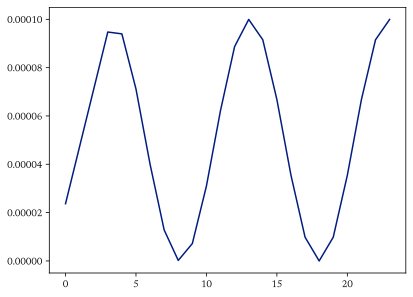

In [25]:
plt.plot(lr_history)

#### **Losses**

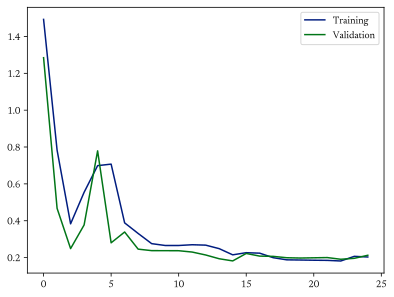

In [26]:
plt.plot(training_losses, label='Training')
plt.plot(evaluation_losses, label='Validation')
plt.legend()
plt.show()

In [27]:
# for batch in train_loader:
#     input_ids, logits, type_indicator, target_token = yuri.process_batch(batch, 'yes_token')
#     loss, log_prob_target = yuri.compute_loss(input_ids, logits, type_indicator, target_token)
#     print(target_token)
#     print(tokenizer.decode(target_token))
#     generated_ids = yuri.model.generate(
#                         input_ids=input_ids[:,:-2],
#                         max_new_tokens=2,
#                         temperature=0.001)  # Ensure temperature is set here)
#     decoded_batch_texts = yuri.tokenizer.batch_decode(generated_ids, skip_special_tokens=False)
#     print(decoded_batch_texts)
#     break



In [28]:
_, _, log_probs, indicators, target, fstage, outcomes, texts = yuri.evaluate(data_loader=all_loader, token_type='yes_token', return_decoded_text=True, max_new_tokens=2)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:128001 for

In [29]:
_, _, log_probs_treatment, _, _, _, _ = yuri.evaluate(data_loader=treated_loader, token_type='yes_token', return_decoded_text=False, max_new_tokens=2)
_, _, log_probs_control, _, _, _, _ = yuri.evaluate(data_loader=control_loader, token_type='yes_token', return_decoded_text=False, max_new_tokens=2)


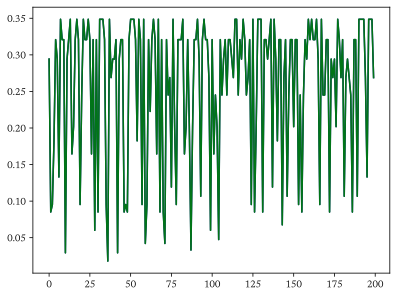

In [30]:
plt.plot(np.exp(log_probs_treatment))
plt.plot(np.exp(log_probs_control))
plt.show()

In [31]:
Y = np.array(outcomes)
residuals = np.exp(log_probs).reshape(-1,1) - (0.5*np.exp(log_probs_treatment).reshape(-1,1) + 0.5*np.exp(log_probs_control).reshape(-1,1) )

(array([53., 10., 16.,  0., 10.,  4.,  9.,  6.,  9., 83.]),
 array([-0.34104624, -0.30415934, -0.26727241, -0.2303855 , -0.19349858,
        -0.15661167, -0.11972475, -0.08283783, -0.04595092, -0.009064  ,
         0.02782291]),
 <BarContainer object of 10 artists>)

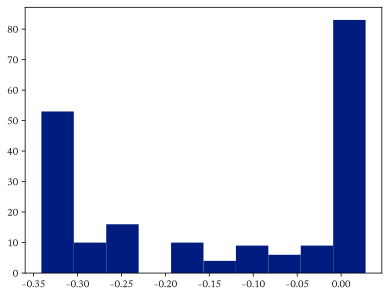

In [32]:
plt.hist(residuals)

In [33]:
est = np.linalg.lstsq( np.hstack((residuals, np.ones_like(residuals))), Y)[0]
est

array([1.7375456, 0.5049148], dtype=float32)

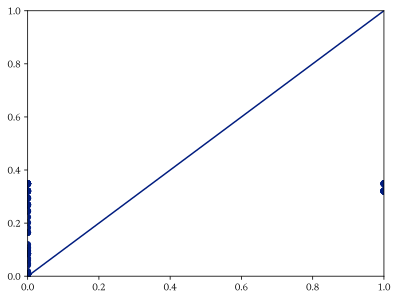

In [34]:
plt.scatter(np.array(fstage)*np.array(indicators.to('cpu')), np.exp(log_probs))
plt.plot([0,1], [0, 1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [35]:
x = tokenizer.apply_chat_template(dataset['messages'][1], tokenize=True, skip_special_tokens=False)
tokenizer.decode(x[-2])

'No'

In [36]:
for i, (j, k, l) in enumerate(zip(log_probs, target, texts)):
    print(f"Target : {k}, {torch.exp(j):.4f}")
    display(to_markdown(l))
    if i > 20:
        break

Target : No, 0.0086


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 52-year-old individual with mobility impairments who has been living in a two-story duplex for the past 22 months. They are currently behind on their rent by $750. Despite the challenges posed by their mobility issues, the tenant has managed to maintain a small art studio within their home, where they regularly create and display their artwork. To help cover the rent, the tenant receives financial contributions from their family members, who play a crucial role in supporting their living situation.
> 
>  Note: The tenant does not have access to a free lawyer.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.0097


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 57-year-old individual who has been residing in a two-story duplex for the past 8 months. They are currently behind on rent, owing $661 to their landlord. The tenant has several behavioral traits and conditions that contribute to their financial and living situation. They live with a roommate who also contributes to the rent payments. Despite their financial struggles, the tenant has a deep passion for attending theater performances and often finds solace in the arts. Alongside their human companion, the tenant also shares their home with a beloved bird, adding a touch of liveliness to their living space.
> 
>  Note: The tenant does not have access to a free lawyer.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.0097


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a young individual in their mid-20s who is currently struggling to make ends meet and pay the $1269 monthly rent for their two-story duplex. They have been living in this residence for 42 months and face the added challenge of mobility impairments, which can make navigating the two-story home difficult. Despite these obstacles, the tenant takes joy in exploring different cuisines and trying new recipes, a passion that likely provides a welcome respite from their financial worries. The tenant lives with a roommate who contributes to the rent, but the combined income is still insufficient to cover the full cost. With a beloved pet bird also sharing the home, the tenant is determined to find a way to maintain their living situation and continue pursuing their culinary interests.
> 
>  Note: The tenant does not have access to a free lawyer.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.1824


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a mid-40s individual with mobility impairments who has been living in a two-story duplex for the past 45 months. They are currently late on their $1251 rent payment. The tenant lives with a roommate who contributes to the rent, and the tenant occasionally works from home due to their mobility challenges. Despite their living situation, the tenant has no pets.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : Yes, 0.3486


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 37-year-old individual with mobility impairments, living in a three-story duplex with a housing voucher. They have been residing in the duplex for the past 26 months and have a pet bird. Despite having a housing voucher, the tenant is currently behind on rent, owing $1,151. The tenant's family, who do not contribute to the rent, lives nearby, and the tenant frequently interacts with their neighbors in the duplex.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.0086


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 47-year-old individual with mobility impairments, living in a small apartment complex for the past 4 years. They are currently struggling to pay the $766 monthly rent due to their limited income. The tenant lives with a roommate who does not contribute to the rent, adding to the financial burden. Despite these challenges, the tenant frequently interacts with their neighbors, seeking support and camaraderie within the small community they call home. With a beloved cat as their companion, the tenant navigates the complexities of maintaining a stable living situation while managing their physical limitations.
> 
>  Note: The tenant does not have access to a free lawyer.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.0097


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 32-year-old individual with mobility impairments who lives in a three-story duplex with a housing voucher. They have been residing in the duplex for 34 months and share the unit with a roommate who contributes to the rent. The tenant has fallen behind on their rent by $664. Despite their challenges, the tenant finds solace in their hobbies, particularly knitting and other crafts, which they enjoy during their spare time. The tenant's living situation, combined with their financial difficulties and mobility constraints, presents unique challenges that they must navigate within the context of their housing situation.
> 
>  Note: The tenant does not have access to a free lawyer.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.3486


> <|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 48-year-old individual with mobility impairments, living in a large apartment complex for the past 6 months. They currently owe $834 in rent. Despite having a roommate who does not contribute to the rent, the tenant has managed to cultivate a collection of board games, which they enjoy playing in their free time. The tenant's living situation is challenging, as they navigate their mobility issues while also trying to keep up with the financial responsibilities of the apartment.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.0097


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 38-year-old individual who is currently facing difficulties in paying their monthly rent of $1321. They have been residing in a small apartment complex for the past 28 months and do not have any pets. The tenant struggles with various psychiatric disorders, which have impacted their ability to maintain a steady income. Despite their passion for food and dining out at new restaurants, their family members do not contribute to the rent, leaving the tenant to manage the financial burden alone. The tenant's situation highlights the challenges faced by many individuals with mental health conditions who are trying to balance their personal lives, employment, and housing responsibilities.
> 
>  Note: The tenant does not have access to a free lawyer.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.0097


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 48-year-old individual who has been residing in a three-story duplex for the past 21 months. They are currently behind on rent, owing $1,031. The tenant struggles with psychiatric disorders, which have likely contributed to their financial difficulties. Despite this, they find solace in playing chess with friends, a hobby they deeply enjoy. Complicating the situation, the tenant's roommate does not contribute to the rent, placing an additional burden on the tenant's already strained financial circumstances.
> 
>  Note: The tenant does not have access to a free lawyer.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.0110


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 47-year-old individual with mobility impairments, living in a small apartment complex they have occupied for the past 39 months. They are currently late on their rent of $1,326. The tenant lives with a roommate who contributes to the rent, and they enjoy passing their free time playing video games to stay entertained.
> 
>  Note: The tenant does not have access to a free lawyer.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.0097


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 43-year-old individual with mobility impairments, currently residing in a large apartment complex for the past 11 months. Despite their best efforts, they have fallen behind on their rent, which amounts to $1372. Despite living in the spacious apartment, they face the challenge of managing their disability, which affects their ability to maintain steady employment. Alongside their residence, they have a small garden on the balcony, where they find solace and a connection to nature. Regrettably, their family members do not contribute to the rent, leaving the tenant to shoulder the financial burden alone. Additionally, the tenant takes comfort in the presence of a fish tank, which provides a calming and therapeutic environment amidst the difficulties they face.
> 
>  Note: The tenant does not have access to a free lawyer.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.0097


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 52-year-old individual with mobility impairments, currently living in a two-story duplex with a housing voucher. They have been residing in this duplex for 32 months and have a beloved dog as a companion. Despite their financial challenges, they have a small garden on the balcony, which provides them with a sense of tranquility and connection to nature. The tenant's family members contribute to the rent, helping to cover the outstanding amount of $842. This situation highlights the complexities faced by individuals with disabilities in maintaining stable housing, while also finding solace in the simple pleasures of tending to their own small garden.
> 
>  Note: The tenant does not have access to a free lawyer.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.0097


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 35-year-old individual who has been residing in a small apartment complex for the past 18 months. They are currently behind on rent, owing $958. The tenant has been struggling with chronic illnesses, which have impacted their ability to maintain consistent employment and meet their financial obligations. Despite their health challenges, they find solace in playing chess with friends, a hobby that provides them with a mental escape. Their family members, unfortunately, do not contribute to the rent, leaving the tenant to shoulder the burden alone. Despite the difficulties, the tenant remains resilient, determined to find a way to address their outstanding rent and maintain their home, which includes a beloved bird that provides them with much-needed companionship.
> 
>  Note: The tenant does not have access to a free lawyer.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.1645


> <|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 55-year-old individual who has been living in a two-story duplex for the past 46 months. They are currently behind on their rent by $1055. The tenant faces chronic health issues that have impacted their ability to maintain steady employment and meet their financial obligations. Despite these challenges, they find solace in exploring local history and landmarks, a passion they deeply cherishes. Complicating the situation further, the tenant lives with a roommate who does not contribute to the rent, adding to the financial strain. With a cat as a constant companion, the tenant navigates the delicate balance of managing their health, maintaining their living situation, and pursuing their love for local history.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.0097


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a middle-aged individual in their early-40s who is currently struggling to pay the $720 rent for their three-story duplex home. They have been living in this residence for the past 19 months, and their mobility is impaired, making navigating the multi-level home challenging. Despite their difficulties, the tenant frequently interacts with their neighbors, seeking support and understanding. Unfortunately, the tenant's living situation is further complicated by a roommate who does not contribute to the rent payments, adding to the financial strain. Despite these obstacles, the tenant remains determined to maintain their housing and continue their involvement with the local community.
> 
>  Note: The tenant does not have access to a free lawyer.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.0086


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 48-year-old individual with mobility impairments, currently living in a two-story duplex they have occupied for the past 31 months. Despite their artistic inclinations, as evidenced by the small art studio they maintain at home, the tenant has fallen behind on rent, owing $770. Living with a cat, the tenant's family does not contribute to the rent payments, adding to the financial strain. This combination of factors, including the tenant's mobility challenges and the lack of familial support, creates a complex situation for the housing court to navigate.
> 
>  Note: The tenant does not have access to a free lawyer.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.3486


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 42-year-old individual with mobility impairments, living in a large apartment complex for the past 52 months. They are currently behind on rent by $980. Despite their challenges, the tenant remains active in local charity events, demonstrating a commitment to community involvement. Complicating the situation further, the tenant's roommate does not contribute to the rent payments. This added financial strain has made it increasingly difficult for the tenant to stay current on their housing obligations.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.3208


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a middle-aged individual in their late-50s who is currently behind on their rent by $1478. They have been living in a small apartment complex for the past 12 months and have a hearing impairment that affects their daily life. Despite their financial challenges, the tenant has managed to create a small garden on their balcony, finding solace in tending to the plants. They share their modest apartment with a roommate who contributes to the rent, providing some financial support. The tenant's companion, a beloved bird, adds a touch of liveliness to their home, providing them with companionship during these difficult times.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.0953


> <|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a young, visually impaired individual in their mid-20s who has been living in a two-story duplex for the past 19 months. Despite their visual impairments, they have managed to establish a comfortable life in their rented home. Unfortunately, they have fallen behind on their rent, which currently stands at $1,125. To make ends meet, the tenant relies on financial contributions from their family members to help cover the monthly payments. However, this has not been an easy situation for them. In their free time, the tenant finds solace in baking, often sharing the delicious treats they create with their friendly neighbors, showcasing their passion and talent for the culinary arts.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.2451


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 57-year-old individual who has been residing in a three-story duplex for the past 32 months. They are currently struggling to pay the $988 monthly rent due to their psychiatric disorders, which have made it challenging for them to maintain steady employment. Despite the support of a local book club they participate in, the tenant's family members do not contribute to the rent payments. The tenant's living situation is further complicated by the presence of a dog, which adds an additional financial burden. This combination of factors has placed the tenant in a precarious position, as they strive to keep a roof over their head while managing their mental health and personal obligations.
> 
>  Note: The tenant has access to a free lawyer. Access to a lawyer does not mean the tenant will be represented in court by a lawyer. If the tenant is given access to a lawyer, they must apply for representation. Because more tenants apply than can be represented, legal aid providers prioritize tenants with **vouchers** and **disabilities** when reviewing applications. Providers can differ over what they consider to be a dissability. If a tenant's application is selected, they must follow-up with the provider to arange for legal representation. Therefor it's possible that tenants with characteristics which sugges they they should be prioritized remain without representation.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

Target : No, 0.0086


> <|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|eot_id|><|begin_of_text|><|start_header_id|>system<|end_header_id|>
> 
> You are a housing court clerk<|eot_id|><|start_header_id|>user<|end_header_id|>
> 
> Task: Based on the following information, predict (Yes/No) whether the tenant will be represented in court by a lawyer.
> 
>  Description:The tenant is a 37-year-old individual with mobility impairments, living in a large apartment complex for the past 53 months. Despite their efforts, they have fallen behind on their rent by $747. With a cat as their companion, the tenant faces the challenges of managing their household expenses and living with a disability. Their family, though present, does not contribute to the rent payments. However, the tenant finds solace in volunteering at a local animal shelter, where they can connect with the community and support a cause they care about.
> 
>  Note: The tenant does not have access to a free lawyer.<|eot_id|><|start_header_id|>assistant<|end_header_id|>
> 
> No<|eot_id|>

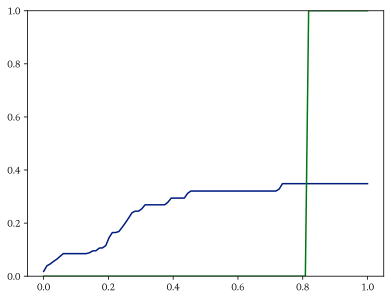

In [37]:
qs = np.linspace(0, 1, 100)
ys1 = np.quantile(np.exp(log_probs)[indicators.to('cpu') == 1], qs)
ys2 = np.quantile(df['FStage_Value'].values, qs)
plt.plot(qs, ys1)
plt.plot(qs, ys2)
plt.ylim(0, 1)
plt.show()

In [38]:
# Ensure probabilities are within (0, 1) to avoid log(0)
epsilon = 1e-15
probabilities = np.clip(df['FStage_Value'].values*df['Instrument'].values, epsilon, 1 - epsilon)

# Compute binary cross-entropy loss
bce_loss = -np.mean(df['Treatment'].values * np.log(probabilities) + (1 - df['Treatment'].values) * np.log(1 - probabilities))

print(f'Binary Cross-Entropy Loss: {bce_loss}')

Binary Cross-Entropy Loss: 9.992007221626413e-16
